In [4]:

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from helper_functions import *
from skimage.io import imread

In [2]:
import ee
ee.Authenticate()

True

In [3]:
ee.Initialize(project="ee-kaywee")

In [5]:
### BY COUNTY

# Importing and separating just for grains
corn_yield = pd.read_csv('CornProductive_byCounty.csv')
corn_grain = corn_yield[(corn_yield['YIELD in BU / ACRE'] != ' ') & \
                        (corn_yield['COMMODITY'] == 'CORN, GRAIN')][['YEAR', 'LOCATION', 'STATE ANSI', 'COUNTY ANSI', 'YIELD in BU / ACRE', 'AREA HARVESTED in ACRES']] \
             .rename(columns={'STATE ANSI':'STATE_FIPS', 'COUNTY ANSI':'COUNTY_FIPS', 'YIELD in BU / ACRE':'YIELD', 'AREA HARVESTED in ACRES':'AREA'})
corn_silage = corn_yield[(corn_yield['YIELD in TONS / ACRE'] != ' ') & (corn_yield['COMMODITY'] == 'CORN, SILAGE')]

# Drop those that combined counties/ and no areas of planting and make sure it's int
corn_grain = corn_grain[corn_grain['COUNTY_FIPS'] != ' ']
corn_grain = corn_grain[corn_grain['AREA'] != ' '].reset_index().drop(['index'], axis=1)
corn_grain['COUNTY_FIPS'] = corn_grain['COUNTY_FIPS'].map(int)
corn_grain['AREA'] = corn_grain['AREA'].apply(lambda a: int(a.replace(',', '')))
corn_grain['YIELD'] = corn_grain['YIELD'].map(float)
corn_grain['TOTAL_YIELD'] = corn_grain.apply(lambda row: (row['AREA']*row['YIELD']), axis=1)

unique_data = sorted([list(x) for x in set(tuple(x) for x in corn_grain[['STATE_FIPS', 'COUNTY_FIPS']].values)])
fips_data = [location for location in unique_data if location not in [[46, 102], [51, 131]]] #51, 131 = All nan, 46, 102 = no results
len(fips_data)

print('There are a total of {} states with {} counties in the dataset.'.format(len(corn_grain['STATE_FIPS'].unique()), len(unique_data)))
display(corn_grain.head())
corn_grain.to_csv('corn_grain.csv')

There are a total of 32 states with 1889 counties in the dataset.


,YEAR,LOCATION,STATE_FIPS,COUNTY_FIPS,YIELD,AREA,TOTAL_YIELD
0,2018,"ALABAMA, BLACK BELT, AUTAUGA",1,1,165.6,900,149040.0
1,2018,"ALABAMA, BLACK BELT, DALLAS",1,47,137.3,4900,672770.0
2,2018,"ALABAMA, BLACK BELT, ELMORE",1,51,170.5,2100,358050.0
3,2018,"ALABAMA, BLACK BELT, PERRY",1,105,145.2,6100,885720.0
4,2018,"ALABAMA, COASTAL PLAINS & GULF COAST, BALDWIN",1,3,152.0,7000,1064000.0


In [45]:
corn_grain.dtypes

YEAR             int64
LOCATION        object
STATE_FIPS       int64
COUNTY_FIPS      int64
YIELD          float64
AREA             int64
TOTAL_YIELD    float64
dtype: object

# DATA VIZ

# SATELITTE IMAGING

In [6]:
# Getting county level information and statistics
# Note that the function is designed for more than one pic --> becareful with USDA which only give 1 pic per year

target_sat = {'USDA/NASS/CDL':['cropland'], \
              'MODIS/061/MYD11A2':[0,4], \
              'MODIS/061/MOD09A1':[0,1,2,3,4,5,6] \
        }  
folders = ['USDA_CROP', \
           'MODIS_TEMP', \
           'MODIS_LAND'
           ]
locations = [(loc[0], loc[1]) for loc in unique_data]
dates = ['2018-1-1', '2023-1-1']
scale  = 500   # 500m = 1 pixel
dates_of_images = {folder:[] for folder in folders}

#################################################################################################

county_region = ee.FeatureCollection('TIGER/2016/Counties')

for folder, target in zip(folders, target_sat):

    if folder == 'USDA_CROP':
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) 
    else:
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))

    # append bands to each image when collected
    img = img_collection.iterate(appendBand)
    if folder == 'USDA_CROP':
        img = ee.Image(img).eq(1)  # only corn 
    else:
        img = ee.Image(img)

    # print basic info (bands and no. of available images)
    dates_of_images[folder] += dates_available(img_collection)
    print('\n ######################### ' + target +  ' #########################')
    print("Total Dates Available: ", len(dates_of_images[folder]))
    print("Dates available: ", dates_of_images[folder])

    collection_bands = available_bands(img_collection)
    for k, v in collection_bands.items():
        print("Band", k, "will be downloaded in", v['number_available'], "images per county. (", v['percent_available'], "%)")
 
"""
    # Getting images
    for i, (loc1, loc2) in enumerate(locations):

        im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
        scale  = scale
        crs = 'EPSG:4326'   # Coordinate Reference System

        # filter for a county
        region = county_region.filterMetadata('STATEFP', 'equals', int(loc1))
        region = ee.FeatureCollection(region).filterMetadata('COUNTYFP', 'equals', int(loc2))
        region = ee.Feature(region.first()) # get the coordinates and other features

        while True:
            try:
                export_image(img.clip(region), folder, im_name, scale, crs)
            except Exception:
                print(Exception)
                time.sleep(10)
                continue
            break
        if (i%250 == 0) or (i == len(locations)-1):
            print(i)
"""


 ######################### USDA/NASS/CDL #########################
Total Dates Available:  5
Dates available:  ['2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01']
Band cropland will be downloaded in 5 images per county. ( 100.0 %)

 ######################### MODIS/061/MYD11A2 #########################
Total Dates Available:  189
Dates available:  ['2018-03-06', '2018-03-14', '2018-03-22', '2018-03-30', '2018-04-07', '2018-04-15', '2018-04-23', '2018-05-01', '2018-05-09', '2018-05-17', '2018-05-25', '2018-06-02', '2018-06-10', '2018-06-18', '2018-06-26', '2018-07-04', '2018-07-12', '2018-07-20', '2018-07-28', '2018-08-05', '2018-08-13', '2018-08-21', '2018-08-29', '2018-09-06', '2018-09-14', '2018-09-22', '2018-09-30', '2018-10-08', '2018-10-16', '2018-10-24', '2018-11-01', '2018-11-09', '2018-11-17', '2018-11-25', '2018-12-03', '2018-12-11', '2018-12-19', '2018-12-27', '2019-03-06', '2019-03-14', '2019-03-22', '2019-03-30', '2019-04-07', '2019-04-15', '2019-04-23', 

"\n    # Getting images\n    for i, (loc1, loc2) in enumerate(locations):\n\n        im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)\n        scale  = scale\n        crs = 'EPSG:4326'   # Coordinate Reference System\n\n        # filter for a county\n        region = county_region.filterMetadata('STATEFP', 'equals', int(loc1))\n        region = ee.FeatureCollection(region).filterMetadata('COUNTYFP', 'equals', int(loc2))\n        region = ee.Feature(region.first()) # get the coordinates and other features\n\n        while True:\n            try:\n                export_image(img.clip(region), folder, im_name, scale, crs)\n            except Exception:\n                print(Exception)\n                time.sleep(10)\n                continue\n            break\n        if (i%250 == 0) or (i == len(locations)-1):\n            print(i)\n"

In [29]:
# Check number of files

from os import listdir
from os.path import isfile, join

USDA_CROP_path = 'data/USDA_CROP/'
# USDA_MOISTURE_path = 'data/USDA_MOISTURE/'
MODIS_TEMP_path = 'data/MODIS_TEMP/'
MODIS_LAND_path = 'data/MODIS_LAND/'

folder_list = [USDA_CROP_path, MODIS_TEMP_path, MODIS_LAND_path]

USDA_CROP = [f for f in listdir(USDA_CROP_path) if isfile(join(USDA_CROP_path, f))]
MODIS_TEMP = [f for f in listdir(MODIS_TEMP_path) if isfile(join(MODIS_TEMP_path, f))]
MODIS_LAND = [f for f in listdir(MODIS_LAND_path) if isfile(join(MODIS_LAND_path, f))]

# extract FIPS and sort in ascending order
MODIS_TEMP_fips = sorted([file[11:-4] for file in MODIS_TEMP if file[0:10] == 'MODIS_TEMP'])
USDA_CROP_fips = sorted([file[10:-4] for file in USDA_CROP if file[0:9] == 'USDA_CROP'])
MODIS_LAND_fips = sorted([file[11:-4] for file in MODIS_LAND if file[0:10] == 'MODIS_LAND'])

for folder in folder_list:
    seen = set()
    uniq = [x for x in USDA_CROP_fips if x not in seen and not seen.add(x)]
    print('For folder {}, there are {} files in it.'.format(folder, len(uniq)))

For folder data/USDA_CROP/, there are 1779 files in it.
For folder data/MODIS_TEMP/, there are 1779 files in it.
For folder data/MODIS_LAND/, there are 1779 files in it.


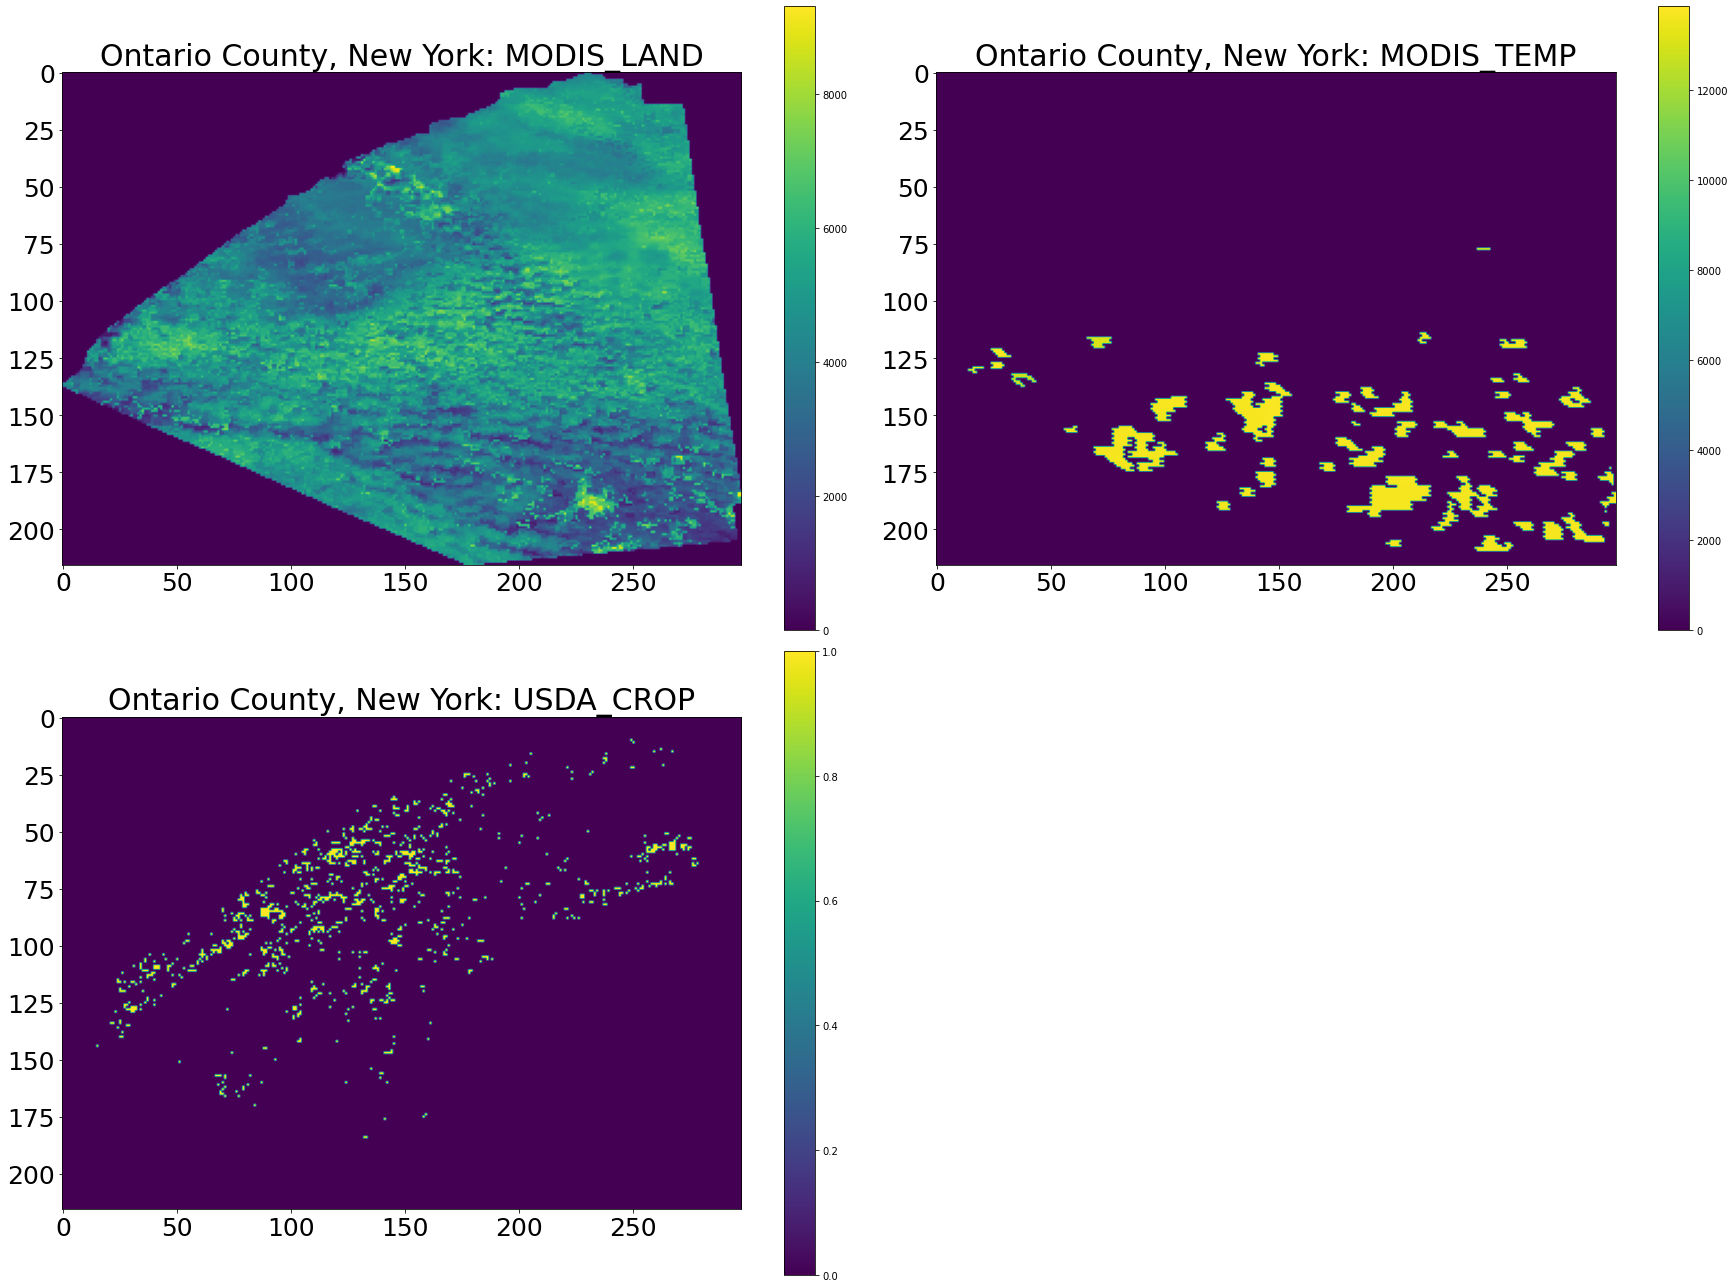

In [44]:
# Example Images
# test_county = '31_109' # Lancaster County, Nebraska
test_county = '36_089'
path = ['MODIS_LAND/MODIS_LAND_', 'MODIS_TEMP/MODIS_TEMP_', 'USDA_CROP/USDA_CROP_']
plt.figure(figsize=(25,18))
for i, file in enumerate(path):
    test = imread('data/' + file + test_county + '.tif')
    plt.subplot(2, 2, i+1) 
    plt.imshow(test[:, :, 0])
    plt.title('Ontario County, New York: ' + file.split('/')[1][:-1], fontsize=30)
    plt.colorbar()
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
plt.savefig('Example Images', dpi=500)
plt.tight_layout()
plt.show()

In [30]:
import os
# Processing image (this one I didn't rerun cause it takes forever)
from tqdm import tqdm
from helper_functions import *

def image_processing_I(filedata):
    path, folder, nband, fips_data, dates_of_images = filedata
    new_dates = {}
    for state, county in tqdm(fips_data):
        # Create path
        imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif' 
        imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(county) + '.tif'

        try:
            # Reading figures
            mask = imread(path + folder[0] + '/' + imname_mask)
            img_1 = imread(path + folder[1] + '/' + imname_folder_1)
            img_2 = imread(path + folder[2] + '/' + imname_folder_2)
        except FileNotFoundError:
            # print(f"Files not found for state {state} and county {county}. Skipping...")
            continue

        mask, new_dates[folder[0]] = filter_year(['2018', '2022'], mask, nband[0], dates_of_images[folder[0]])
        img_1, new_dates[folder[1]] = filter_year(['2018', '2022'], img_1, nband[1], dates_of_images[folder[1]])
        img_2, new_dates[folder[2]] = filter_year(['2018', '2022'], img_2, nband[2], dates_of_images[folder[2]])

        # Making sure the bands of the figure are correct
        if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]):
            print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2])
            raise ValueError('Dimension of the matrix is not correct.')

        # Zero fill NaN
        img_2 = zero_fill(img_2)

        if count_img_nan(img_2) > 0:
            print('The number of NaN in MODIS_LAND, Temp, and USDA_CROP are {}, {}, and {}. \
            in {} state and {} county'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(mask), state, county))

        # Splitting images by year
        img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
        img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])

        # Masking
        # for i, img_year in enumerate(img_1_list):
        #     for j in range(img_year.shape[2]):
        #         img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]
        # for i, img_year in enumerate(img_2_list):
        #     for j in range(img_year.shape[2]):
        #         img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]
        # Masking
        for i, img_year in enumerate(img_1_list):
            # Check if i is within the valid range
            if i < mask.shape[2]:
                for j in range(img_year.shape[2]):
                    # Check if j is within the valid range
                    if j < mask.shape[2]:
                        img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]

        for i, img_year in enumerate(img_2_list):
            # Check if i is within the valid range
            if i < mask.shape[2]:
                for j in range(img_year.shape[2]):
                    # Check if j is within the valid range
                    if j < mask.shape[2]:
                        img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]

        
        year_list = list(range(2018, 2023))
        # export images, this part can be improved by using HDF5
        # for i, img_year in enumerate(img_1_list):
        #     np.save(output_path + folder[1] + '/' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        # for i, img_year in enumerate(img_2_list):
        #     np.save(output_path + folder[2] + '/' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        # Make sure the output directory exists
        output_folder = os.path.join(output_path, folder[1])
        os.makedirs(output_folder, exist_ok=True)

        # export images, this part can be improved by using HDF5
        for i, img_year in enumerate(img_1_list):
            np.save(os.path.join(output_folder, f"{year_list[i]}_{state}_{county}.npy"), img_year) 

        # Repeat for the second folder
        output_folder = os.path.join(output_path, folder[2])
        os.makedirs(output_folder, exist_ok=True)

        for i, img_year in enumerate(img_2_list):
            np.save(os.path.join(output_folder, f"{year_list[i]}_{state}_{county}.npy"), img_year)


if __name__ == "__main__":
    path = 'data/'
    folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP']
    nband = [1, 7, 2]
    output_path = "/home/kaywee/Documents/wee's things/cds-corn-prediction/"
    filedata = path, folder, nband, fips_data, dates_of_images
    
    image_processing_I(filedata)

100%|██████████| 1887/1887 [07:30<00:00,  4.19it/s]


In [8]:
plt_MODIS_LAND = plt_img_dist("/home/kaywee/Documents/wee's things/cds-corn-prediction/temp_data/MODIS_LAND", 7, 3000, corn_grain)
plt_MODIS_TEMP = plt_img_dist("/home/kaywee/Documents/wee's things/cds-corn-prediction/temp_data/MODIS_TEMP", 2, 3000, corn_grain)


[[2018    1    1]
 [2018    1   47]
 [2018    1   51]
 ...
 [2023   55   93]
 [2023   55  109]
 [2023   55  121]]


100%|██████████| 3000/3000 [00:00<00:00, 140931.32it/s]


[[2018    1    1]
 [2018    1   47]
 [2018    1   51]
 ...
 [2023   55   93]
 [2023   55  109]
 [2023   55  121]]


100%|██████████| 3000/3000 [00:00<00:00, 159483.28it/s]


100%|██████████| 3000/3000 [00:00<00:00, 131204.57it/s]

Band: 0
Data: []
Number of samples: 0



/home/kaywee/Documents/wee's things/cds-corn-prediction/.venv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1171: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/kaywee/Documents/wee's things/cds-corn-prediction/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/kaywee/Documents/wee's things/cds-corn-prediction/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kaywee/Documents/wee's things/cds-corn-prediction/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: skewtest is not valid with less than 8 samples; 0 samples were given.

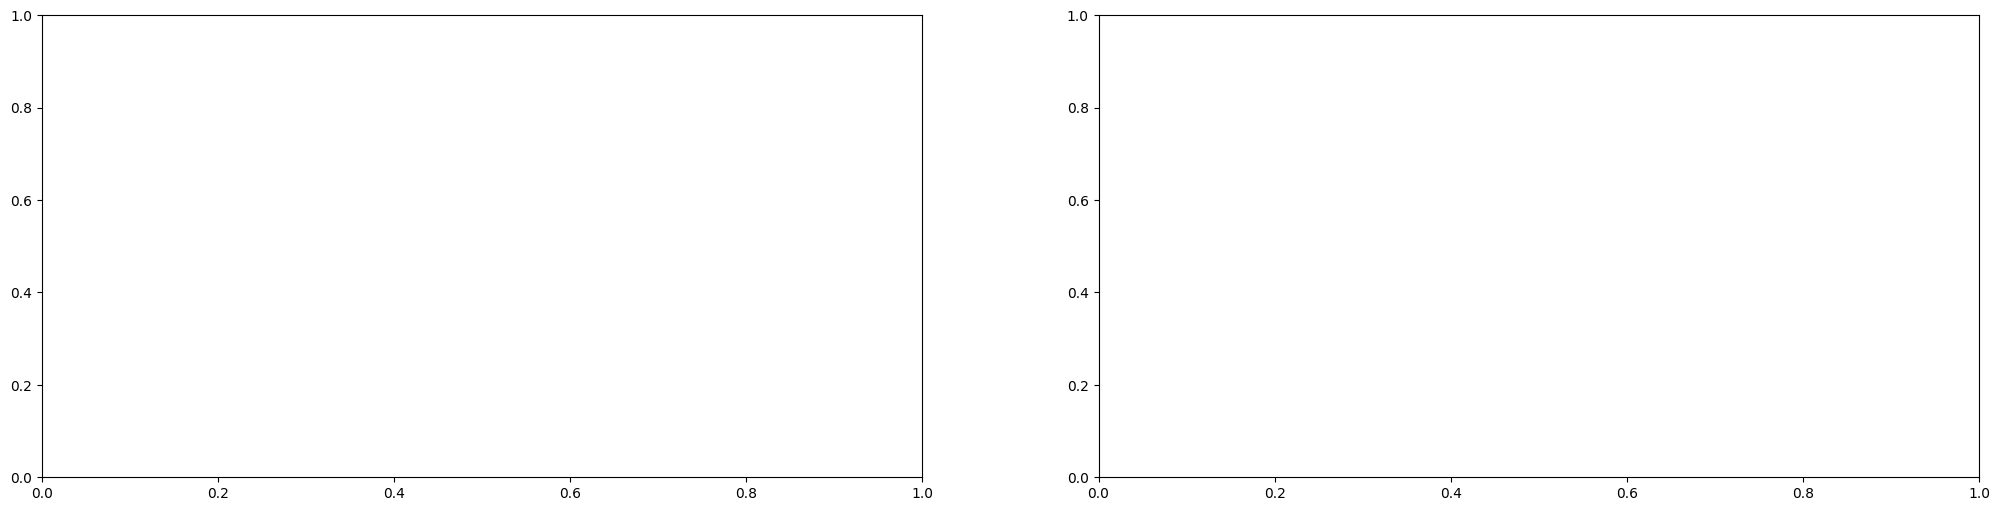

In [41]:
# Plotting distribution of band values in 3000 images
import pylab
from scipy.stats import normaltest

plt_MODIS_LAND = plt_img_dist("/home/kaywee/Documents/wee's things/cds-corn-prediction/temp_data/MODIS_LAND", 7, 3000, corn_grain)
plt_MODIS_TEMP = plt_img_dist("/home/kaywee/Documents/wee's things/cds-corn-prediction/temp_data/MODIS_TEMP", 2, 3000, corn_grain)

cm = pylab.get_cmap('viridis')
band_name = {'MODIS_LAND': [1,2,3,4,5,6,7],
             'MODIS_TEMP': ['Day land surface temperature', 'Night land surface temperature']}
nband = [7, 2]
plt_files = [plt_MODIS_LAND, plt_MODIS_TEMP]
xlabel = ['Spectral Reflectance', 'Surface Temperature (Kelvin)']

f, axs = plt.subplots(1, 2, figsize=(25,6))

for i, (name, plt_file) in enumerate(zip(band_name, plt_files)):
    cm = pylab.get_cmap('magma')

    
    for band in range(nband[i]):

        print("Band:", band)
        print("Data:", plt_file[band])
        print("Number of samples:", len(plt_file[band]))


        color = cm(1.*band/nband[i])
        _, p = normaltest(plt_file[band])
        sns.distplot(plt_file[band], color=color, ax=axs[i], bins=100, \
                     kde_kws={"label": 'Band {}: {} , p-value={:.4f}.'.format(band, band_name[name][band], p)})
        
    axs[i].set_xlabel(xlabel[i], fontsize=MEDIUM_SIZE)
    axs[i].set_ylabel('Normalized Frequency', fontsize=MEDIUM_SIZE)
    
plt.tight_layout()
plt.savefig('band distribution', dpi=500)
plt.show()

In [52]:
# dont need to rerun
# Binning images (this one I didn't rerun cause it takes forever)
from tqdm import tqdm

def create_input_3D(input_dir, fips, output_dir):
    
    resolution = 128
    for fip in tqdm(fips):
        year = fip[0]
        state = fip[1]
        county = fip[2]
        
        try:
            # Reading figures
            img_1 = np.load(input_dir[0] + str(year) +'_' + str(state) + '_' + str(county) + '.npy')
            img_2 = np.load(input_dir[1] + str(year) +'_' + str(state) + '_' + str(county) + '.npy')
        except FileNotFoundError:
            # print(f"Files not found for state {state} and county {county}. Skipping...")
            continue

        bin_MODIS_LAND = get_bin(img_1, [[0, 4000]]*4 + [[0, 5000]]*2 + [[0, 4000]], 7, resolution)
        bin_MODIS_TEMP = get_bin(img_2, [[13500, 15250], [13000, 14250]], 2, resolution)
        # bin_USDA_MOISTURE = get_bin(img_3, [[0, 26], [0, 200]], 2, resolution)

        bin_all = np.concatenate([bin_MODIS_LAND, bin_MODIS_TEMP], axis=0)

        np.save(output_dir + '//' + str(year) + '_' + str(state) + '_' + str(county), bin_all)

if __name__ == "__main__":
    
    fips = corn_grain[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][corn_grain['YEAR'] >= 2018]
    fips = fips[((fips['STATE_FIPS'] != 51) | (fips['COUNTY_FIPS'] != 131)) & \
               ((fips['STATE_FIPS'] != 46) | (fips['COUNTY_FIPS'] != 102))]
    
    pd.DataFrame(fips).to_csv("data/processed_fips.csv")
 
    fips = fips[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']].values

    # fips.to_csv('data/processed_fips.csv')
    
    create_input_3D(["/home/kaywee/Documents/wee's things/cds-corn-prediction/temp_data/MODIS_LAND/", 
                    "/home/kaywee/Documents/wee's things/cds-corn-prediction/temp_data/MODIS_TEMP/"], 
                    fips, \
                    'data/PROCESSED')

In [45]:
# Originally we output the processed input as (nband, resolution, frame per year) per file (11077) files
# I just realized that previous shaping was wrong and here we are reshaping it to (frames, 1, resolution, nband)
import glob
import pickle
from tqdm import tqdm 

nband = 9
resolution = 128

for file_name in tqdm(glob.glob('data/PROCESSED/*.npy')):
    year, state, county = file_name[15:-4].split('_')
    print(file_name)
    processed_img = np.load(file_name)
    output_name = ('_').join([year, state, county])
    
    frames = processed_img.shape[2]
    new_processed_img = np.zeros((frames, 1, resolution, nband))
    for frame in range(frames):
        for band in range(nband):
            new_processed_img[frame, :, :, band] = processed_img[band, :, frame]
    np.save('data/PROCESSED_II/' + output_name + '.npy', new_processed_img)

 10%|█         | 244/2368 [00:00<00:01, 1216.94it/s]

data/PROCESSED/2018_31_161.npy
data/PROCESSED/2019_28_143.npy
data/PROCESSED/2020_37_135.npy
data/PROCESSED/2019_29_175.npy
data/PROCESSED/2019_29_211.npy
data/PROCESSED/2020_48_321.npy
data/PROCESSED/2021_21_219.npy
data/PROCESSED/2021_20_137.npy
data/PROCESSED/2021_39_101.npy
data/PROCESSED/2021_21_163.npy
data/PROCESSED/2021_21_173.npy
data/PROCESSED/2020_40_103.npy
data/PROCESSED/2018_31_133.npy
data/PROCESSED/2018_21_213.npy
data/PROCESSED/2018_13_209.npy
data/PROCESSED/2020_39_103.npy
data/PROCESSED/2019_19_123.npy
data/PROCESSED/2021_18_107.npy
data/PROCESSED/2021_19_129.npy
data/PROCESSED/2020_19_111.npy
data/PROCESSED/2018_18_179.npy
data/PROCESSED/2021_27_135.npy
data/PROCESSED/2021_21_217.npy
data/PROCESSED/2018_18_119.npy
data/PROCESSED/2019_19_157.npy
data/PROCESSED/2021_28_135.npy
data/PROCESSED/2020_18_103.npy
data/PROCESSED/2021_29_115.npy
data/PROCESSED/2020_55_103.npy
data/PROCESSED/2021_27_133.npy
data/PROCESSED/2020_27_161.npy
data/PROCESSED/2020_19_109.npy
data/PRO

 15%|█▌        | 366/2368 [00:00<00:01, 1199.96it/s]

data/PROCESSED/2018_26_145.npy
data/PROCESSED/2018_39_143.npy
data/PROCESSED/2021_19_171.npy
data/PROCESSED/2021_27_125.npy
data/PROCESSED/2018_26_157.npy
data/PROCESSED/2019_19_133.npy
data/PROCESSED/2018_47_107.npy
data/PROCESSED/2021_42_111.npy
data/PROCESSED/2020_19_147.npy
data/PROCESSED/2019_48_215.npy
data/PROCESSED/2018_21_181.npy
data/PROCESSED/2019_47_149.npy
data/PROCESSED/2021_29_189.npy
data/PROCESSED/2018_29_147.npy
data/PROCESSED/2020_18_175.npy
data/PROCESSED/2021_21_231.npy
data/PROCESSED/2020_18_107.npy
data/PROCESSED/2020_27_105.npy
data/PROCESSED/2021_19_141.npy
data/PROCESSED/2018_37_177.npy
data/PROCESSED/2021_39_117.npy
data/PROCESSED/2020_20_101.npy
data/PROCESSED/2018_17_161.npy
data/PROCESSED/2021_40_107.npy
data/PROCESSED/2021_21_145.npy
data/PROCESSED/2019_39_161.npy
data/PROCESSED/2018_17_203.npy
data/PROCESSED/2020_17_127.npy
data/PROCESSED/2021_46_111.npy
data/PROCESSED/2018_47_179.npy
data/PROCESSED/2021_48_111.npy
data/PROCESSED/2021_21_105.npy
data/PRO

 26%|██▌       | 607/2368 [00:00<00:01, 1193.11it/s]

data/PROCESSED/2021_21_157.npy
data/PROCESSED/2020_20_151.npy
data/PROCESSED/2021_22_117.npy
data/PROCESSED/2019_51_149.npy
data/PROCESSED/2019_48_209.npy
data/PROCESSED/2020_40_131.npy
data/PROCESSED/2020_21_175.npy
data/PROCESSED/2018_28_117.npy
data/PROCESSED/2018_27_165.npy
data/PROCESSED/2018_48_491.npy
data/PROCESSED/2020_37_109.npy
data/PROCESSED/2018_17_193.npy
data/PROCESSED/2019_13_201.npy
data/PROCESSED/2018_38_101.npy
data/PROCESSED/2019_18_157.npy
data/PROCESSED/2021_47_165.npy
data/PROCESSED/2019_48_149.npy
data/PROCESSED/2018_26_119.npy
data/PROCESSED/2019_21_227.npy
data/PROCESSED/2020_21_117.npy
data/PROCESSED/2021_28_155.npy
data/PROCESSED/2020_51_197.npy
data/PROCESSED/2021_37_177.npy
data/PROCESSED/2018_29_165.npy
data/PROCESSED/2020_29_135.npy
data/PROCESSED/2018_19_185.npy
data/PROCESSED/2019_19_161.npy
data/PROCESSED/2019_39_121.npy
data/PROCESSED/2021_39_157.npy
data/PROCESSED/2019_17_193.npy
data/PROCESSED/2021_19_175.npy
data/PROCESSED/2019_17_109.npy
data/PRO

 36%|███▌      | 847/2368 [00:00<00:01, 1190.31it/s]

data/PROCESSED/2021_29_201.npy
data/PROCESSED/2018_46_135.npy
data/PROCESSED/2020_29_129.npy
data/PROCESSED/2020_40_139.npy
data/PROCESSED/2019_21_177.npy
data/PROCESSED/2018_20_175.npy
data/PROCESSED/2018_51_119.npy
data/PROCESSED/2021_13_251.npy
data/PROCESSED/2019_47_185.npy
data/PROCESSED/2019_19_163.npy
data/PROCESSED/2021_21_213.npy
data/PROCESSED/2019_47_153.npy
data/PROCESSED/2018_21_221.npy
data/PROCESSED/2019_47_107.npy
data/PROCESSED/2019_51_127.npy
data/PROCESSED/2021_27_147.npy
data/PROCESSED/2021_40_141.npy
data/PROCESSED/2019_21_137.npy
data/PROCESSED/2019_19_175.npy
data/PROCESSED/2021_47_163.npy
data/PROCESSED/2018_20_131.npy
data/PROCESSED/2021_31_135.npy
data/PROCESSED/2018_27_143.npy
data/PROCESSED/2020_13_251.npy
data/PROCESSED/2021_20_179.npy
data/PROCESSED/2020_55_133.npy
data/PROCESSED/2019_20_149.npy
data/PROCESSED/2019_13_313.npy
data/PROCESSED/2019_29_151.npy
data/PROCESSED/2020_20_131.npy
data/PROCESSED/2018_19_113.npy
data/PROCESSED/2018_48_111.npy
data/PRO

 46%|████▌     | 1086/2368 [00:00<00:01, 1182.01it/s]

data/PROCESSED/2019_26_127.npy
data/PROCESSED/2020_55_111.npy
data/PROCESSED/2020_37_187.npy
data/PROCESSED/2020_13_137.npy
data/PROCESSED/2021_27_167.npy
data/PROCESSED/2018_18_167.npy
data/PROCESSED/2020_21_191.npy
data/PROCESSED/2019_13_119.npy
data/PROCESSED/2019_37_177.npy
data/PROCESSED/2021_28_139.npy
data/PROCESSED/2020_21_105.npy
data/PROCESSED/2019_55_137.npy
data/PROCESSED/2020_26_161.npy
data/PROCESSED/2018_18_113.npy
data/PROCESSED/2018_18_117.npy
data/PROCESSED/2020_26_149.npy
data/PROCESSED/2021_20_111.npy
data/PROCESSED/2018_31_169.npy
data/PROCESSED/2021_26_137.npy
data/PROCESSED/2019_19_153.npy
data/PROCESSED/2020_28_135.npy
data/PROCESSED/2021_27_165.npy
data/PROCESSED/2021_37_127.npy
data/PROCESSED/2020_47_109.npy
data/PROCESSED/2021_48_277.npy
data/PROCESSED/2020_19_197.npy
data/PROCESSED/2019_17_163.npy
data/PROCESSED/2019_31_155.npy
data/PROCESSED/2019_36_103.npy
data/PROCESSED/2019_47_125.npy
data/PROCESSED/2018_47_125.npy
data/PROCESSED/2020_27_111.npy
data/PRO

 56%|█████▌    | 1324/2368 [00:01<00:00, 1170.36it/s]

data/PROCESSED/2020_17_141.npy
data/PROCESSED/2019_39_169.npy
data/PROCESSED/2020_17_111.npy
data/PROCESSED/2020_37_103.npy
data/PROCESSED/2020_29_105.npy
data/PROCESSED/2019_21_225.npy
data/PROCESSED/2018_19_125.npy
data/PROCESSED/2021_55_141.npy
data/PROCESSED/2021_13_315.npy
data/PROCESSED/2020_27_121.npy
data/PROCESSED/2020_48_209.npy
data/PROCESSED/2020_48_179.npy
data/PROCESSED/2020_27_157.npy
data/PROCESSED/2018_48_463.npy
data/PROCESSED/2021_55_119.npy
data/PROCESSED/2020_36_109.npy
data/PROCESSED/2020_55_141.npy
data/PROCESSED/2021_19_133.npy
data/PROCESSED/2018_13_199.npy
data/PROCESSED/2018_39_173.npy
data/PROCESSED/2021_20_181.npy
data/PROCESSED/2021_21_225.npy
data/PROCESSED/2018_19_175.npy
data/PROCESSED/2019_20_187.npy
data/PROCESSED/2019_19_139.npy
data/PROCESSED/2018_47_123.npy
data/PROCESSED/2018_48_233.npy
data/PROCESSED/2019_31_151.npy
data/PROCESSED/2020_13_193.npy
data/PROCESSED/2018_48_217.npy
data/PROCESSED/2020_20_207.npy
data/PROCESSED/2020_39_165.npy
data/PRO

 66%|██████▌   | 1557/2368 [00:01<00:00, 1137.15it/s]

data/PROCESSED/2019_31_163.npy
data/PROCESSED/2021_29_207.npy
data/PROCESSED/2020_18_109.npy
data/PROCESSED/2020_27_145.npy
data/PROCESSED/2021_36_111.npy
data/PROCESSED/2019_39_105.npy
data/PROCESSED/2019_18_107.npy
data/PROCESSED/2021_39_151.npy
data/PROCESSED/2020_18_121.npy
data/PROCESSED/2019_51_137.npy
data/PROCESSED/2021_21_161.npy
data/PROCESSED/2020_18_181.npy
data/PROCESSED/2021_27_109.npy
data/PROCESSED/2020_39_125.npy
data/PROCESSED/2021_36_115.npy
data/PROCESSED/2021_13_267.npy
data/PROCESSED/2018_17_187.npy
data/PROCESSED/2018_47_163.npy
data/PROCESSED/2019_18_171.npy
data/PROCESSED/2020_21_163.npy
data/PROCESSED/2020_17_181.npy
data/PROCESSED/2019_27_133.npy
data/PROCESSED/2020_17_113.npy
data/PROCESSED/2021_27_111.npy
data/PROCESSED/2019_37_133.npy
data/PROCESSED/2020_29_163.npy
data/PROCESSED/2020_47_111.npy
data/PROCESSED/2020_26_123.npy
data/PROCESSED/2018_19_183.npy
data/PROCESSED/2021_37_193.npy
data/PROCESSED/2019_39_119.npy
data/PROCESSED/2018_39_115.npy
data/PRO

 75%|███████▌  | 1785/2368 [00:01<00:00, 1136.32it/s]

data/PROCESSED/2018_18_165.npy
data/PROCESSED/2019_28_103.npy
data/PROCESSED/2019_37_193.npy
data/PROCESSED/2019_31_131.npy
data/PROCESSED/2021_29_177.npy
data/PROCESSED/2019_29_107.npy
data/PROCESSED/2019_48_293.npy
data/PROCESSED/2020_31_143.npy
data/PROCESSED/2019_20_135.npy
data/PROCESSED/2018_37_197.npy
data/PROCESSED/2018_13_139.npy
data/PROCESSED/2018_19_165.npy
data/PROCESSED/2018_28_149.npy
data/PROCESSED/2021_39_169.npy
data/PROCESSED/2019_17_167.npy
data/PROCESSED/2020_13_275.npy
data/PROCESSED/2020_21_187.npy
data/PROCESSED/2020_29_141.npy
data/PROCESSED/2021_27_115.npy
data/PROCESSED/2021_17_121.npy
data/PROCESSED/2021_26_147.npy
data/PROCESSED/2019_51_175.npy
data/PROCESSED/2019_17_141.npy
data/PROCESSED/2020_19_129.npy
data/PROCESSED/2019_17_199.npy
data/PROCESSED/2020_20_187.npy
data/PROCESSED/2020_37_139.npy
data/PROCESSED/2019_18_135.npy
data/PROCESSED/2019_31_133.npy
data/PROCESSED/2020_13_315.npy
data/PROCESSED/2021_40_103.npy
data/PROCESSED/2018_55_105.npy
data/PRO

 85%|████████▍ | 2012/2368 [00:01<00:00, 1127.09it/s]

data/PROCESSED/2020_48_255.npy
data/PROCESSED/2018_13_279.npy
data/PROCESSED/2018_19_167.npy
data/PROCESSED/2021_18_177.npy
data/PROCESSED/2021_47_103.npy
data/PROCESSED/2018_31_101.npy
data/PROCESSED/2021_37_143.npy
data/PROCESSED/2020_21_211.npy
data/PROCESSED/2018_39_175.npy
data/PROCESSED/2021_19_115.npy
data/PROCESSED/2019_42_109.npy
data/PROCESSED/2018_20_115.npy
data/PROCESSED/2019_20_205.npy
data/PROCESSED/2020_20_129.npy
data/PROCESSED/2018_28_125.npy
data/PROCESSED/2019_17_137.npy
data/PROCESSED/2018_17_199.npy
data/PROCESSED/2018_19_127.npy
data/PROCESSED/2021_21_113.npy
data/PROCESSED/2020_18_127.npy
data/PROCESSED/2020_42_131.npy
data/PROCESSED/2020_29_117.npy
data/PROCESSED/2019_26_151.npy
data/PROCESSED/2020_21_207.npy
data/PROCESSED/2021_20_113.npy
data/PROCESSED/2021_29_227.npy
data/PROCESSED/2019_20_133.npy
data/PROCESSED/2018_17_173.npy
data/PROCESSED/2018_37_161.npy
data/PROCESSED/2019_19_171.npy
data/PROCESSED/2020_39_145.npy
data/PROCESSED/2021_48_437.npy
data/PRO

 95%|█████████▍| 2239/2368 [00:01<00:00, 1129.02it/s]

data/PROCESSED/2018_18_115.npy
data/PROCESSED/2018_47_115.npy
data/PROCESSED/2018_28_119.npy
data/PROCESSED/2019_18_113.npy
data/PROCESSED/2020_21_225.npy
data/PROCESSED/2020_39_101.npy
data/PROCESSED/2019_37_159.npy
data/PROCESSED/2019_17_139.npy
data/PROCESSED/2020_48_507.npy
data/PROCESSED/2019_48_325.npy
data/PROCESSED/2018_48_395.npy
data/PROCESSED/2020_21_171.npy
data/PROCESSED/2021_48_469.npy
data/PROCESSED/2021_37_185.npy
data/PROCESSED/2020_20_109.npy
data/PROCESSED/2021_29_183.npy
data/PROCESSED/2020_39_151.npy
data/PROCESSED/2019_27_159.npy
data/PROCESSED/2021_13_175.npy
data/PROCESSED/2019_48_451.npy
data/PROCESSED/2021_37_115.npy
data/PROCESSED/2020_22_107.npy
data/PROCESSED/2020_37_157.npy
data/PROCESSED/2021_17_147.npy
data/PROCESSED/2019_37_143.npy
data/PROCESSED/2020_17_175.npy
data/PROCESSED/2018_20_113.npy
data/PROCESSED/2020_51_119.npy
data/PROCESSED/2019_26_123.npy
data/PROCESSED/2021_55_107.npy
data/PROCESSED/2021_13_177.npy
data/PROCESSED/2018_26_149.npy
data/PRO

100%|██████████| 2368/2368 [00:02<00:00, 1157.83it/s]

data/PROCESSED/2020_26_121.npy
data/PROCESSED/2020_26_125.npy
data/PROCESSED/2019_37_103.npy
data/PROCESSED/2020_20_181.npy
data/PROCESSED/2020_48_489.npy
data/PROCESSED/2019_21_215.npy
data/PROCESSED/2018_31_153.npy
data/PROCESSED/2020_20_183.npy
data/PROCESSED/2020_48_147.npy
data/PROCESSED/2019_13_107.npy
data/PROCESSED/2018_20_129.npy
data/PROCESSED/2020_26_127.npy
data/PROCESSED/2020_19_177.npy
data/PROCESSED/2018_42_107.npy
data/PROCESSED/2021_26_159.npy
data/PROCESSED/2019_17_187.npy
data/PROCESSED/2019_26_125.npy
data/PROCESSED/2018_17_189.npy
data/PROCESSED/2020_29_127.npy
data/PROCESSED/2020_29_189.npy
data/PROCESSED/2020_19_113.npy
data/PROCESSED/2021_27_155.npy
data/PROCESSED/2021_42_119.npy
data/PROCESSED/2021_21_185.npy
data/PROCESSED/2018_42_117.npy
data/PROCESSED/2018_17_191.npy
data/PROCESSED/2019_37_169.npy
data/PROCESSED/2018_51_137.npy
data/PROCESSED/2020_51_181.npy
data/PROCESSED/2019_21_197.npy
data/PROCESSED/2018_48_453.npy
data/PROCESSED/2019_47_179.npy
data/PRO

In [3]:
# The previous preprocessing we forgot that the mask from satellites can cause some images become all zeros
# although the USDA data says it has yields. This discrepancy cause the image to be nan during the binning process.

import glob
import pickle
from tqdm import tqdm 
import numpy as np

count_nonnan = 0
removed_ID = []
for filename in tqdm(glob.glob('data/PROCESSED_II/*.npy')):
    file = np.load(filename)
    if np.sum(np.isnan(file)) == 0:
        np.save('data/PROCESSED_III/' + filename[18:-4] + '.npy', file)
        count_nonnan += 1
    else:
        removed_ID += [filename[18:-4]]
print('The number of processed files with no nan is {} from the original of {}.'.format(count_nonnan, len(glob.glob('data/PROCESSED_II/*.npy'))))
pickle.dump(removed_ID, open("data/removed_ID.p", "wb" ) )

100%|██████████| 2368/2368 [00:02<00:00, 831.28it/s]

The number of processed files with no nan is 1763 from the original of 2368.


In [5]:
# Preparing {county_year:yield} dictionary data for model evaluation
import pandas as pd
# Load fips and other data
fips = pd.DataFrame(pd.read_csv('data/processed_fips.csv').drop(['Unnamed: 0'], axis=1))
corn_grain = pd.read_csv('corn_grain.csv').drop(['Unnamed: 0'], axis=1)
fips_yields = corn_grain.merge(fips)[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS', 'YIELD']].astype(str)
fips_yields['YIELD'] = fips_yields['YIELD'].astype(float)
fips_yields['ID'] = fips_yields.apply(lambda row: row['YEAR'] + '_' + row['STATE_FIPS'] + \
                                      '_' + row['COUNTY_FIPS'], axis=1)
# Remove the IDs with Nans
removed_ID = pd.DataFrame(removed_ID, columns=['ID'])
fips_yields = fips_yields[~fips_yields['ID'].isin([i[0] for i in removed_ID.values.tolist()])]

fips_yields = fips_yields.set_index('ID')
display(fips_yields.head())

print('\n' + '#'*13, 'YIELD MAPPING', '#'*13)

yields_train = fips_yields[['YIELD']][fips_yields['YEAR'] != '2022'].to_dict()['YIELD'] # data from year 2010-2015
yields_test = fips_yields[['YIELD']][fips_yields['YEAR'] == '2022'].to_dict()['YIELD'] # data form year 2016

keys = ['train', 'validation']
values = [yields_train, yields_test]
yields = {key:value for key, value in zip(keys, values)}

for key in list(yields['train'].keys())[0:5]:
    print(key, '=',  yields['train'][key])
print('#'*41)
pickle.dump(yields, open("data/yields.p", "wb" ) )

,YEAR,STATE_FIPS,COUNTY_FIPS,YIELD
ID,,,,
2018_1_1,2018,1,1,165.6
2018_1_47,2018,1,47,137.3
2018_1_51,2018,1,51,170.5
2018_1_105,2018,1,105,145.2
2018_1_3,2018,1,3,152.0



############# YIELD MAPPING #############
2018_1_1 = 165.6
2018_1_47 = 137.3
2018_1_51 = 170.5
2018_1_105 = 145.2
2018_1_3 = 152.0
#########################################
